In [1]:
%%HTML
<div style="text-align: center">
    <span style="font-size: 3em; font-weight: 700; font-family: Consolas">
        Project: House Price Regression
    </span>
    <br><br>
    <span style="">
        A project for intelligent-data-analytics @ 18CLC-KHMT
    </span>
</div>
<div style="page-break-after: always"></div>
<p align="center">
  <img src="https://i.imgur.com/7fqAQix.gif" alt="animated" />
</p>

<!-- Add banner here -->
# About this project

## Collaborators

- `18127231` **Đoàn Đình Toàn** ([@t3bol90](https://github.com/t3bol90))
- `18127080` **Kiều Vũ Minh Đức** ([@kvmduc](https://github.com/kvmduc))
- `18127261` **Nguyễn Công Anh Khoa**([@MachineGun3008](https://github.com/MachineGun3008))
- `18127266` **Trần Quỳnh Như**([@tqnhu2407](https://github.com/tqnhu2407))

## Project Title:

**House Price Prediction**

**Keywords**: `Modeling`; `Regression`; `Data Analytics`.



# Step 0a: Dataset retrieval


If token is not manually uploaded in the first place...
```
from google.colab import files
files.upload() #upload kaggle.json
```

Install Kaggle, auth, then download dataset
```
# Install Kaggle from PyPI
!pip install -q kaggle

# Kaggle: auth
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

```

## Step 0b: Giới thiệu cuộc thi

**Bài toán đặt ra**: Bạn có thông tin nhà - bạn cần dự đoán giá nhà từ thông tin nhà đầu vào.

Link cuộc thi: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

**Mô tả data:** Data thông tin nhà `The Ames House` (có thể kéo về bằng Kaggle API như hướng dẫn phía trên).

Độ đo: RMSE $\sqrt{ \frac{1}{n} \sum_{i}^{n} (\hat y_i - y_i)}^2$


# Step 1: Exploratory data analysis

Đầu tiên ta sẽ cố định lại các yếu tố ảnh hưởng tới tính ngẫu nhiên của code (trong phạm vi ta có thể làm, vì các yếu tố chẳng hạn như sự ngẫu nhiên của GPU trong từng phiên bản CUDA ta không can thiệp được). Điều này giúp code của chúng ta 'tất định' và mang tính reproducibility.

In [2]:
"""
Seed random state to reproduce result
Cite: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
"""
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
"""
Bỏ thông báo lỗi để 'đẹp hơn' - nhưng 'khi làm' thì 'không nên'
"""
import warnings
warnings.filterwarnings('ignore')

Thêm vào các thư viện cần thiết cho việc khám phá dữ liệu

In [4]:
"""
Thư viện dùng để EDA
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

In [5]:
"""
Load data lên
"""
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
"""
Check shape
"""
'Test:', test_df.shape, 'Train:', train_df.shape

('Test:', (1459, 80), 'Train:', (1460, 81))

Data chia làm 2 tập: train set và test set. Trong đó train set có 81 trường, 1460 dòng và test set có 80 trường 1459 dòng.

In [7]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


Chúng ta cần dự đoán giá nhà với các features từ tập test, và ghi vào file csv theo định dạng Id - giá nhà.

### Phân tích cột cần dự đoán: SalePrice

In [11]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

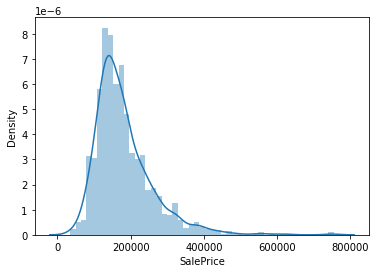

In [12]:
fig = sns.distplot(train_df['SalePrice'])

Phân phối lệch trái (positive skewness) với cái đuôi dài (long-tailed). Giải thích vấn đề này ảnh hưởng "xấu" như thế nào nếu để nguyên và cố gắng dự đoán bằng mô hình thống kê hay máy học truyền thống ở đây [STATSEX-267078](https://stats.stackexchange.com/questions/267078/why-is-skewed-data-not-preferred-for-modelling)

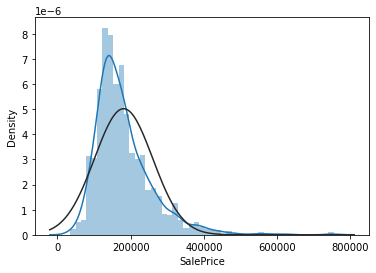

In [13]:
sns.distplot(train_df['SalePrice'], fit=stats.norm);

Phân phối bị lệch khỏi phân phối chuẩn.

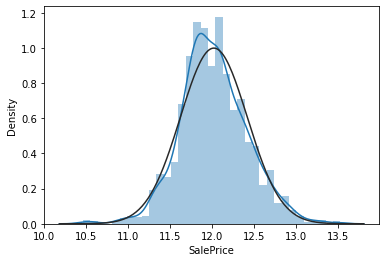

In [14]:
sns.distplot(np.log(train_df['SalePrice']), fit=stats.norm);

Ta có thể dùng log transform để khắc phục điều này. Về mặt kỹ thuật, ta sẽ cố gắng dự đoán $\hat y = log(g)$ do đó:   
- Hàm mục tiêu của mô hình $f_\theta(x)$ sẽ là tối thiểu $d(\hat y, y)$ và dự đoán của chúng ta sẽ là $\hat g = exp(\hat y)$.
- Các cột numeric có quan hệ tương quan với cột SalePrice và cũng có dạng long-tail cũng cần phải transform.

### Phân tích các mối quan hệ giữa các cột khác đối với cột SalePrice

Có 81 cột (rõ ràng là rất là nhiều) - đó ta nên dành quan tâm cho các cột có corr mạnh đủ rõ để có thể quan sát và đánh giá (scaled).

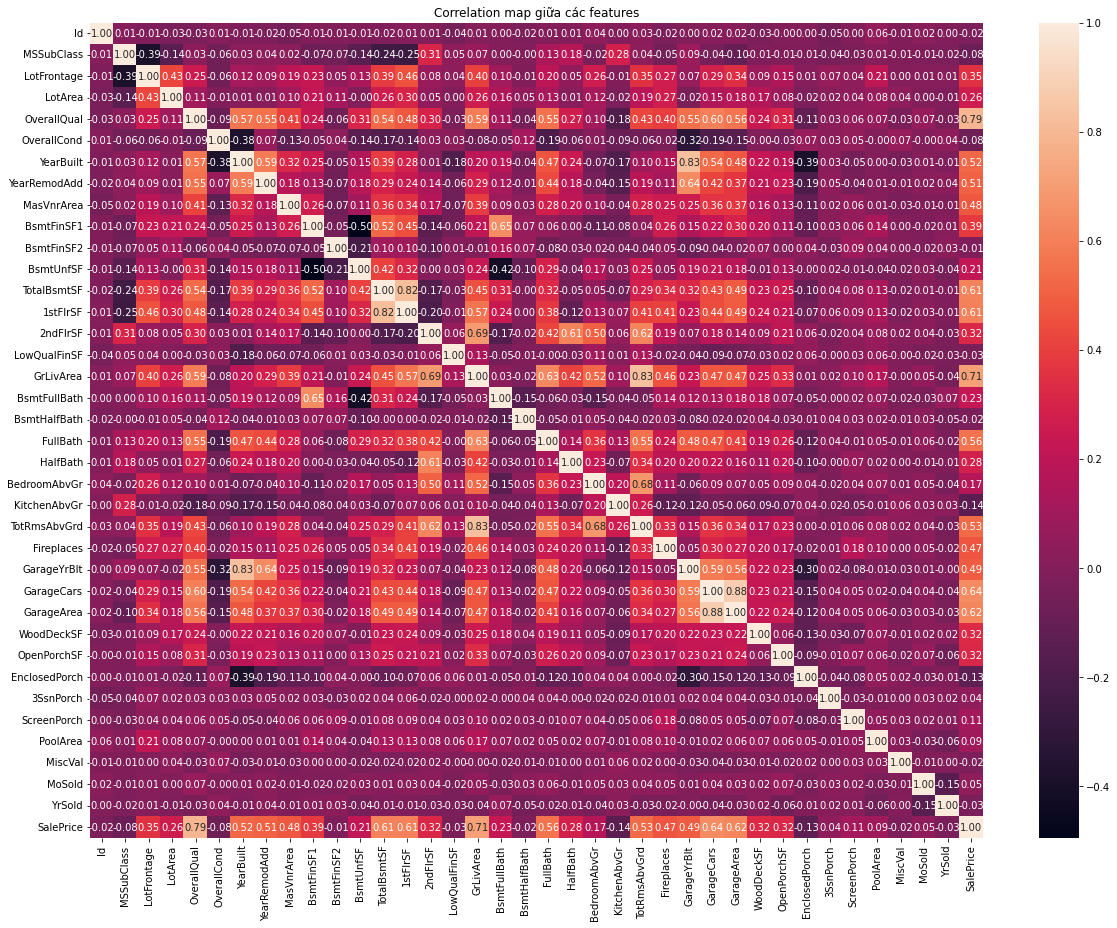

In [15]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(train_df.corr(),ax=ax, annot=True, fmt=".2f")
ax.set_title("Correlation map giữa các features");

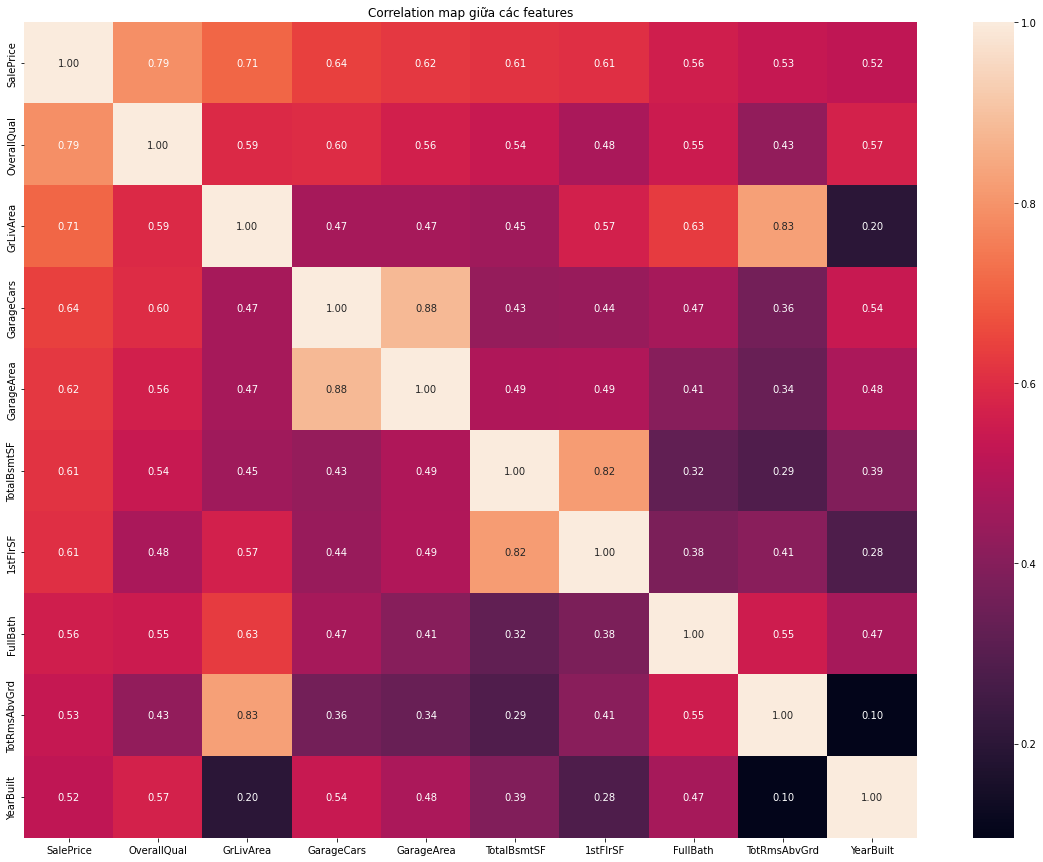

In [16]:
fig, ax = plt.subplots(figsize=(20,15))
cm = train_df.corr().nlargest(10,'SalePrice')
cm = cm[cm.index]
sns.heatmap(cm,ax=ax, annot=True, fmt=".2f")
ax.set_title("Correlation map giữa các features");

Chúng ta có thể thấy:   
- Top 6: "OveralQual", "GLivArea", "GarageCars","GarageArea" "TotalBsmtFS", "1stFlrSF".
- Các cặp "GarageCars","GarageArea" - "TotalBsmtFS", "1stFlrSF" có vẻ là tương quan mạnh với nhau.

# Step 2: Data cleaning

### Kiểm tra missing value ở tập train

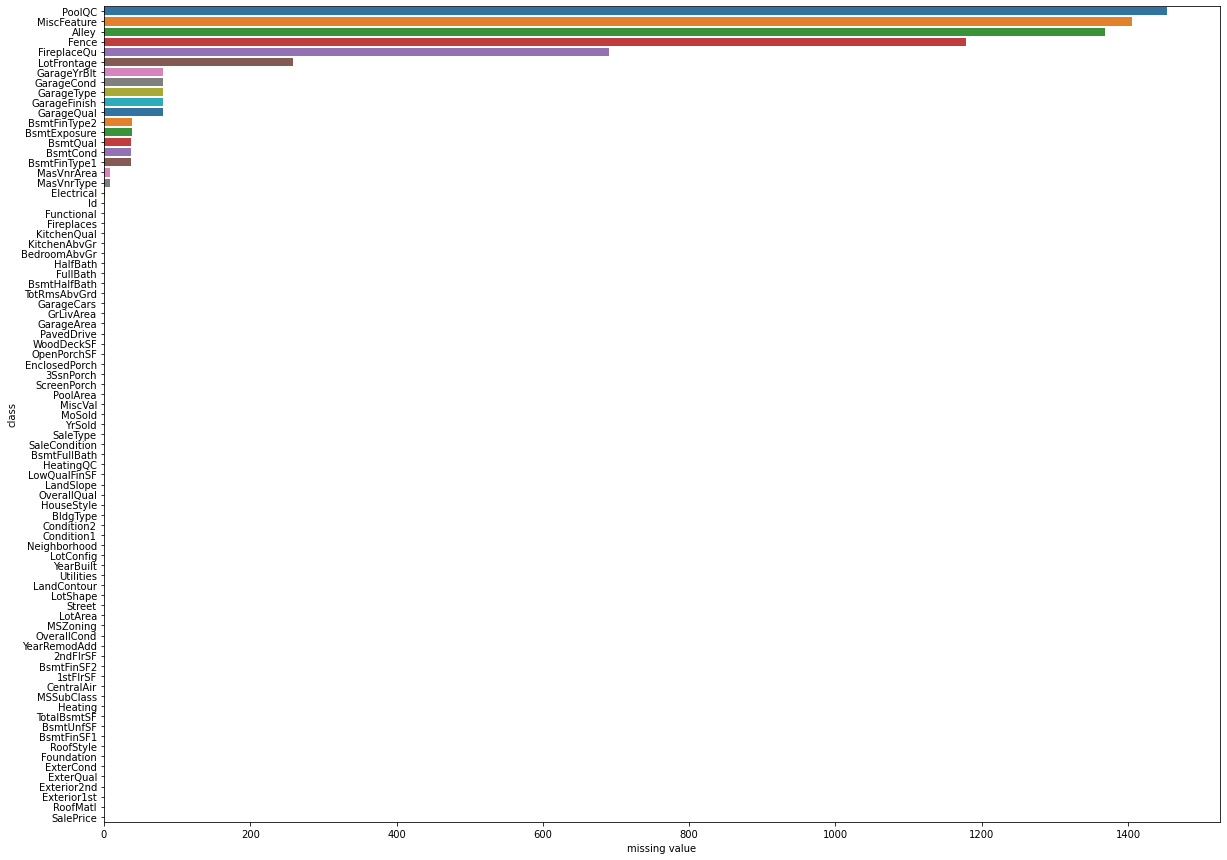

In [17]:
"""
Kiem tra missing value
"""
train_cols = {'class': [], 'missing value': []}
for col in train_df.columns.values:
  train_cols['class'].append(col)
  train_cols['missing value'].append(train_df[col].isnull().sum())

train_mis_data = pd.DataFrame.from_dict(train_cols)

train_mis_data.sort_values(by='missing value',inplace=True,ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(ax=ax,y='class',x='missing value',data=train_mis_data,palette="tab10");


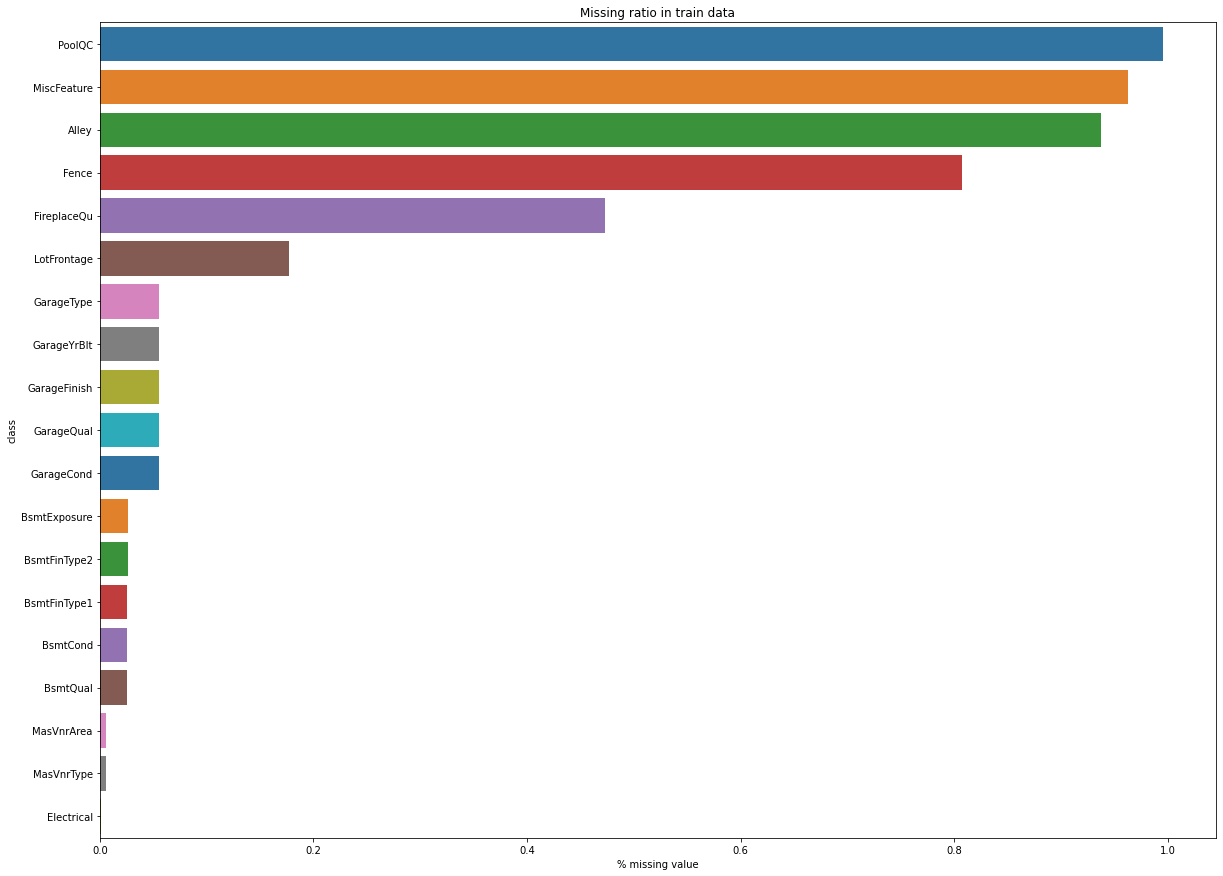

In [18]:
"""
Kiem tra missing value percentage
"""
train_cols = {'class': [], '% missing value': []}

missing_features =[f for f in train_df.columns if train_df[f].isnull().sum()>0]
for feature in missing_features:
  train_cols['class'].append(feature)
  train_cols['% missing value'].append(train_df[feature].isnull().mean())


train_mis_data = pd.DataFrame.from_dict(train_cols)
# train_mis_data
train_mis_data.sort_values(by='% missing value',inplace=True,ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(ax=ax,y='class',x='% missing value',data=train_mis_data,palette="tab10")
ax.set_title("Missing ratio in train data");

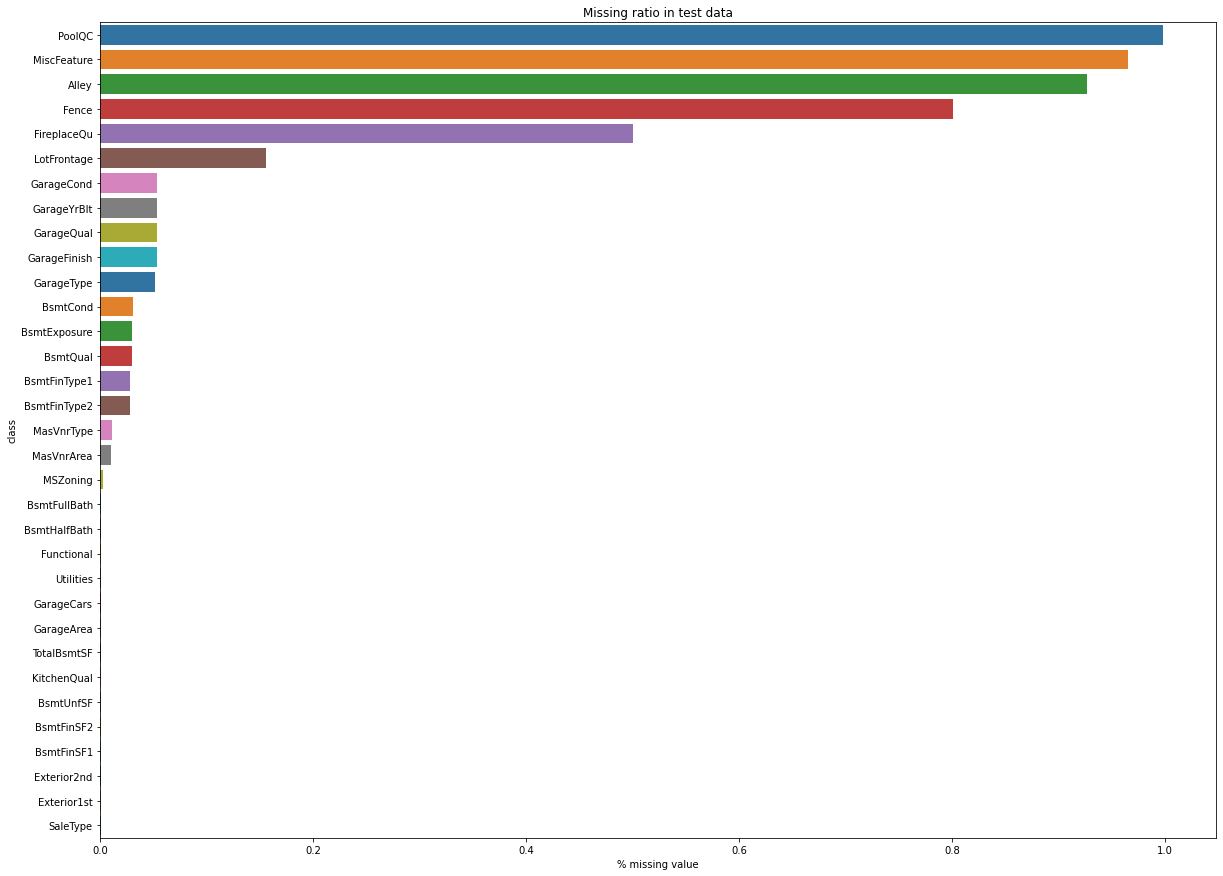

In [19]:
"""
Kiem tra missing value percentage tren tap test
"""
test_cols = {'class': [], '% missing value': []}

missing_features =[f for f in test_df.columns if test_df[f].isnull().sum()>0]
for feature in missing_features:
    test_cols['class'].append(feature)
    test_cols['% missing value'].append(test_df[feature].isnull().mean())


test_mis_data = pd.DataFrame.from_dict(test_cols)
test_mis_data.sort_values(by='% missing value',inplace=True,ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(ax=ax,y='class',x='% missing value',data=test_mis_data,palette="tab10")
ax.set_title("Missing ratio in test data");

## Xử lí các dạng missing value

In [20]:
features_missing_value = [col for col in train_df.columns if train_df[col].isnull().sum()>0]
numerical_cols = [col for col in train_df.columns if train_df[col].dtype != 'O']
temporal_cols = [col for col in numerical_cols if 'Year' in col or 'Yr' in col]
discrete_cols = [col for col in numerical_cols if len(train_df[col].unique()) <=25 and col not in temporal_cols + ['Id']]

continuous_cols = [col for col in numerical_cols if col not in discrete_cols + temporal_cols + ['Id']]
categorial_cols = [col for col in train_df.columns if train_df[col].dtypes == 'O']

### Fill missing data ở các cột categorical

Các cột này đa phần đều là 'Missing có nghĩa', ví dụ như N/A nghĩa là không có tầng hầm. Đây coi như là một class mới - do đó ta có thể fill tất cả bằng một class mới là Missing.

In [21]:
categorial_missing_value = [col for col in categorial_cols if train_df[col].isnull().sum() > 0]

In [22]:
for col in categorial_missing_value:
  train_df[col].fillna('Missing', inplace=True)

Đồng thời cũng cần fill cho tập test

In [23]:
categorial_missing_value = [col for col in categorial_cols if test_df[col].isnull().sum() > 0]
for col in categorial_missing_value:
  test_df[col].fillna('Missing', inplace=True)

### Fill missing data ở các cột numerical


Một số cột numerical liên quan tới các cột category ở trên, ví dụ như không có tầng hầm thì diện tích tầng hầm sẽ là 0.

In [24]:
numerical_related_missing_cols = ['MasVnrArea','GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
for col in numerical_related_missing_cols:
  train_df[col].fillna(0, inplace=True)
  test_df[col].fillna(0, inplace=True)

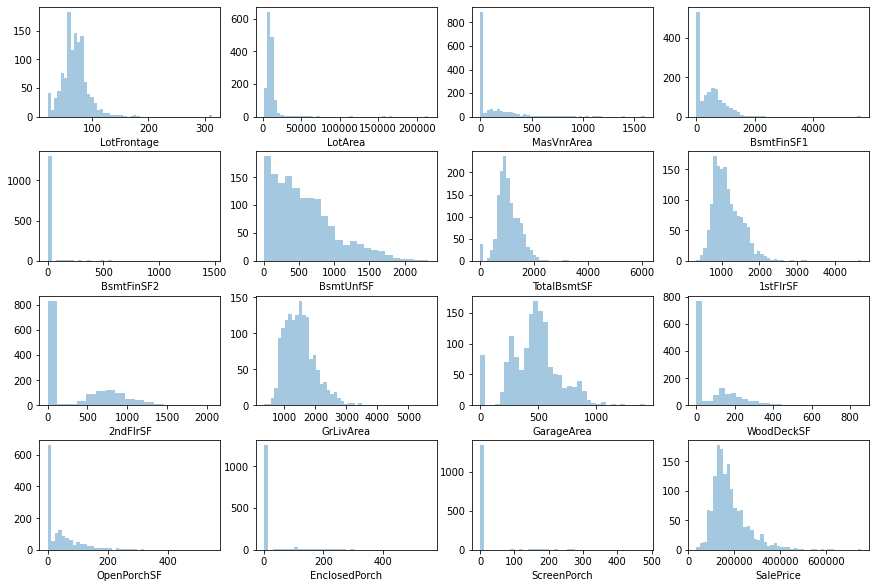

In [26]:
fig = plt.figure(figsize=(12,8))
for index,col in enumerate(continuous_cols):
    plt.subplot(4,4,index+1)
    sns.distplot(train_df[col].dropna(), kde=False);
fig.tight_layout(pad=0.1)

Có thể thấy các cột 'LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea' là các cột cần skew lại.

Đối với các cột còn lại, ta có thể fill bằng median

In [27]:
numerical_missing_value = [col for col in numerical_cols if train_df[col].isnull().sum() > 0]
for col in numerical_missing_value:
  if col not in numerical_related_missing_cols:
    train_df[col].fillna(train_df[col].median(), inplace=True)

**Chú ý rằng ⚡:** ở tập test chúng ta sẽ dùng mean của tập train để fill - vì sẽ bị leak data nếu tiền xử lí tập test bằng data của tập test.

In [28]:
numerical_cols.remove("SalePrice")
numerical_missing_value = [col for col in numerical_cols if test_df[col].isnull().sum() > 0]
for col in numerical_missing_value:
  if col not in numerical_related_missing_cols:
    test_df[col].fillna(train_df[col].median(), inplace=True)

Các cột tương quan dương với SalePrice và có dạng long-tailed thì ta sẽ tiến hành skew data bằng log transform.


In [29]:
skew_cols = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
for col in skew_cols:
  train_df[col] = np.log(train_df[col])

In [30]:
skew_cols = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']
for col in skew_cols:
  test_df[col] = np.log(test_df[col])

# Step 3: Feature engineering

In [31]:
train_data = train_df.copy()
test_data = test_df.copy()

### Tạo feature mới

In [32]:
train_data['TotalFS'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalFS'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

train_data['TotalPorchArea'] = train_data['OpenPorchSF'] + train_data['EnclosedPorch'] + train_data['ScreenPorch'] + train_data['3SsnPorch']
test_data['TotalPorchArea'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['ScreenPorch'] + test_data['3SsnPorch']

train_data['IndoorRatio'] = (train_data['TotalBsmtSF']/train_data['GrLivArea'])
test_data['IndoorRatio'] = (test_data['TotalBsmtSF']/test_data['GrLivArea'])

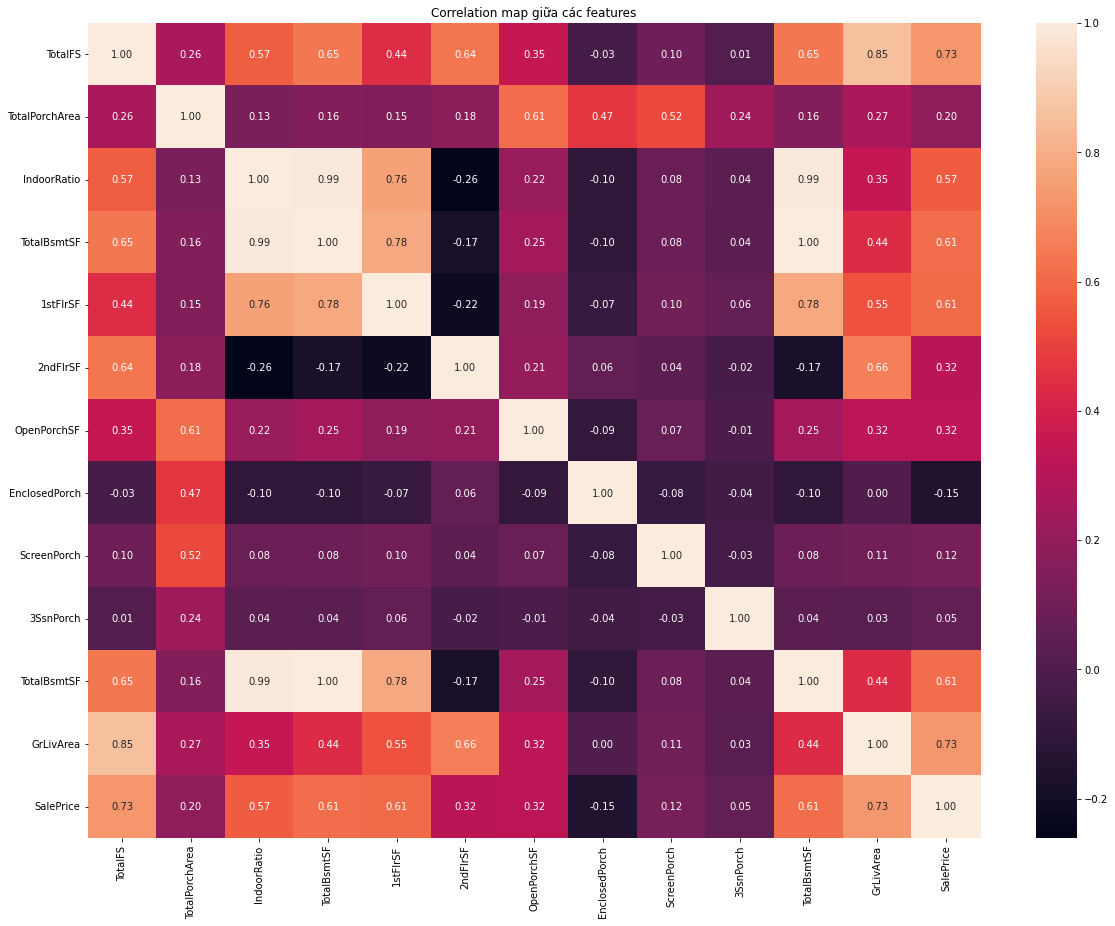

In [33]:
hand_craft = ['TotalFS', 'TotalPorchArea', 'IndoorRatio']
related = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OpenPorchSF', 'EnclosedPorch','ScreenPorch', '3SsnPorch', 'TotalBsmtSF','GrLivArea']
corr_cols = hand_craft + related + ['SalePrice']

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(train_data[corr_cols].corr(),ax=ax, annot=True, fmt=".2f")
ax.set_title("Correlation map giữa các features");

### Đập dẹp và chuẩn hóa

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor


Đập dẹp data

In [35]:

data = pd.concat([train_data,test_data], axis=0)
train_records = train_data.shape[0]
for col in categorial_cols:
  # One hot encoding
  dummy = pd.get_dummies(data[col])
  for col_name in dummy.columns:
      dummy.rename(columns={col_name: f"{col}_{col_name}"}, inplace=True)
  data = pd.concat([data, dummy], axis = 1)
  data.drop([col], axis = 1, inplace=True)
train_data = data.iloc[:train_records, :]
test_data = data.iloc[train_records:, :] 


Chuẩn hóa data

In [36]:
scaling_cols = [col for col in train_data.columns if col not in ['Id', 'SalePrice']]

scaler = StandardScaler()
scaler.fit(train_data[scaling_cols])
X_train = scaler.transform(train_data[scaling_cols])
X_test = scaler.transform(test_data[scaling_cols])

y_train = train_data['SalePrice']

# Step 4: Modeling

## Hồi 1: Baseline model

![](https://i.imgur.com/U0psa6i.png)


Về model chi tiết - xem ở `baseline.ipynb`.

Tóm tắt: Sử dụng Lasso Regression để tạo model baseline.

Kết quả khá khả quan: 0.13516 (khá khả quan), sau khi dùng thêm hand-crafted feature lên 0.1339.

> Vấn đề, làm sao để tune hyperparameters?

Sử dụng các cách như bruteforce + crossvalidation, gridsearch,...
Ví dụ với Lasso thì ta có thể dùng LassoCV để train cùng với cross validation.

Sau đó thì mình có trải nghiệm một số mô hình khác như Decision Tree hay SVR nhưng kết quả không qua baseline.

## Hồi 2: Stack model

![](https://i.imgur.com/Az9ovGh.png)


Chúng ta có thể gộp predict từ nhiều model lại với nhau để tạo ra 'dự đoán chung' và giảm thiểu lỗi từ model.

Hay nói cách khác $\hat g = exp(\frac{1}{n} \sum_{i=1}^{n} b_i\hat y_i)$.


![](https://i.imgur.com/tdoHhfx.png)

Sử dụng Gradient Boosting Machine để làm model thứ 2 stack vào Lasso.

> Với các model có nhiều parameter hơn thì sao? 
Bùng nổ tổ hợp dẫn tới lâu và thiếu hiệu quả.
--> Ta có thể dùng `optuna` hay `dart` để tune param một cách hiệu quả.

Cách này có hiệu quả và đạt kết quả 0.13116 - tốt hơn baseline.

## Hồi 2: Stack nhiều model hơn

Nhóm mình cô gắng thử stack nhiều model khác như SVR, DecisionTree Regression, GradientBoosting Regression (sklearn), ElasticNet.

Và kết quả đi vào ngõ cụt.

![](https://i.imgur.com/Uukkk8i.png)

Sau cùng mình tiến hành giữ lại 4 model và tiến hành tune bằng tay bằng cách spam submit với các tỉ lệ của các model này.

![](https://i.imgur.com/WLVVEmp.png)

![](https://i.imgur.com/pgB6hkh.png)

![](https://i.imgur.com/ZdCzrP9.png)

![](https://i.imgur.com/7cidpZJ.png)


![](https://i.imgur.com/lKeFAbN.png)

Mình đạt được kết quả tốt nhất với tỉ lệ 0:4:2:4, lần lượt là [Lasso, ElasticNet, XGBoost, GradientBoosting Regression].

Qua đây mình có thể rút ra được:    
- Mình có thể submit được 10 (thay vì 5 như quảng cáo).
- Khi gộp team vào thì sẽ giới hạn submit lại (ví dụ 2 người đang có 20 submit/ngày thì gộp thành 1 team chỉ còn được 10 submit/ngày)
- XGBoost là GradientBoosting nhưng hỗ trợ thread (bản GradientBoosting trong sklearn thì không). Do đó sẽ chạy nhanh hơn và tốn ít thời gian tune hơn (với cùng bộ tham số).

## Hồi 4: End-to-end learning & tuning hyperparameters

> Vấn đề mới: Việc (tune bằng tay) này không hiệu quả vì không đạt được end-to-end learning.



Ý tưởng: Chúng ta có thể xem 4 predict trên là một vector - và đưa vào một bộ regression để ra kết quả (ensemble).

![](https://i.imgur.com/8jzmGSh.png)

Kết hợp với các công cụ tuning như `optuna` hay `dart` thì ta có thể end-to-end learning toàn bộ quá trình này và ra kết quả cuối cùng.

Mặc dù vậy, kết quả này chỉ ở mức 'ổn định' chứ không leo top như cách chọn nhờ ông bà phù hộ như trên. 0.13104.

## Kết quả tốt nhất

In [37]:
def rmse(y_train, y_pred):
  return np.sqrt(mean_squared_error(y_train, y_pred))

stacked_model = []

n_splits = 10
def cross_validation(X,y,model):
    return np.mean(np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = n_splits)))

#### Lasso Regression

In [38]:

lasso = Lasso(alpha=0.1,random_state=seed_value)

model = lasso.fit(X_train, y_train)
stacked_model.append(model)
y_pred = model.predict(X_train)
print(("RMSE in train: ", rmse(y_train,y_pred)))

('RMSE in train: ', 0.21391009491670107)


#### ElasticNets


In [39]:
elasticNet = ElasticNet(alpha=0.0005, random_state=seed_value)

model = elasticNet.fit(X_train, y_train)
stacked_model.append(model)
y_pred = model.predict(X_train)
print(("RMSE in train: ", rmse(y_train,y_pred)))

('RMSE in train: ', 0.09167586038277169)


#### XGBoost


In [40]:

xgb =  XGBRegressor(alpha=0.005,
                    colsample_bytree=0.46,
                    gamma=0.005,
                    learning_rate=0.05,
                    max_depth=4,
                    min_child_weight=1.8,
                    n_estimators=3000,
                    reg_alpha=0.5,
                    objective ='reg:squarederror',random_state =seed_value, nthread = -1)

model = xgb.fit(X_train, y_train)
stacked_model.append(model)
y_pred = model.predict(X_train)
print(("RMSE in train: ", rmse(y_train,y_pred)))

('RMSE in train: ', 0.0472535576175388)


#### Gradient Booosting


In [41]:
gradientBoosting = GradientBoostingRegressor(learning_rate=0.12812949640294327,max_depth=4, n_estimators=3000, random_state =seed_value)

model = gradientBoosting.fit(X_train, y_train)
stacked_model.append(model)
y_pred = model.predict(X_train)
print(("RMSE in train: ", rmse(y_train,y_pred)))

('RMSE in train: ', 2.1885829340468494e-05)


# Step 5: Submit

In [42]:
class modelStacker:
  def __init__(self, _stacked,_bias=[0.25, 0.25,0.25,0.25]):
    self.models = _stacked
    self.bias = _bias
  def predict(self, X):
     return self.bias[0]* self.models[0].predict(X) + self.bias[1]* self.models[1].predict(X) + self.bias[2]* self.models[2].predict(X) + self.bias[3]* self.models[3].predict(X)

In [43]:
def make_submission(model):
  try:
    prediction = model.predict(X_test)
    sub = pd.DataFrame()
    sub['Id'] = test_df['Id']
    sub['SalePrice'] = np.exp(prediction)
    sub.to_csv('submission.csv',index=False)
    return True
  except:
    return False

In [44]:
model = modelStacker(stacked_model,[0.0,0.4,0.4,0.2])
make_submission(model)
message = "'Best score submission'"
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m {message}

100% 33.7k/33.7k [00:01<00:00, 18.4kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

<div style="page-break-after: always"></div>

![Footer](https://i.imgur.com/PSMD4pJ.png)